# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [68]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from util import *
from exploratory_data_analysis import *

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [23]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.3.final.0
python-bits: 64
OS: Linux
OS-release: 4.15.0-1060-gcp
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: en_US.UTF-8
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.23.3
pytest: 4.5.0
pip: 18.1
setuptools: 38.4.0
Cython: 0.29.7
numpy: 1.12.1
scipy: 1.2.1
pyarrow: None
xarray: None
IPython: 6.5.0
sphinx: None
patsy: 0.4.1
dateutil: 2.6.1
pytz: 2017.3
blosc: None
bottleneck: None
tables: None
numexpr: 2.6.4
feather: None
matplotlib: 2.1.0
openpyxl: 2.5.0b1
xlrd: 1.1.0
xlwt: None
xlsxwriter: None
lxml: 4.1.1
bs4: 4.6.0
html5lib: 0.9999999
sqlalchemy: 1.1.13
pymysql: None
psycopg2: 2.7.4 (dt dec pq3 ext lo64)
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


## 1. Data Preprocessing
Portfolio Dataframe Tasks:
* Split the channels into several columns.
* Split offer_type into several columns.
* change id column name to offer_id.

In [2]:
portfolio_clean = clean_portfolio(portfolio)

In [9]:
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
difficulty        10 non-null int64
duration          10 non-null int64
offer_id          10 non-null object
offer_type        10 non-null object
reward            10 non-null int64
channel_email     10 non-null uint8
channel_mobile    10 non-null uint8
channel_social    10 non-null uint8
channel_web       10 non-null uint8
dtypes: int64(3), object(2), uint8(4)
memory usage: 520.0+ bytes


In [15]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [10]:
portfolio_clean.head(2)

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


Profile Dataframe Tasks:
* Fix the date
* Change the column name id to customer_id.
* Change id column name to offer_id.
* There are 2,175 missing values in the gender and income columns

In [3]:
profile_clean = clean_profile(profile)

In [11]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
customer_id         17000 non-null object
income              14825 non-null float64
valid               17000 non-null int64
gender_F            17000 non-null uint8
gender_M            17000 non-null uint8
gender_O            17000 non-null uint8
dtypes: datetime64[ns](1), float64(1), int64(2), object(2), uint8(3)
memory usage: 846.8+ KB


In [31]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
profile.head(2)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0


In [12]:
profile_clean.head(2)

,age,became_member_on,gender,customer_id,income,valid,gender_F,gender_M,gender_O
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,1,0,0


Profile Dataframe Tasks:
* Split value in several columns for offers and transactions
* Split event column into sevelar columns
* Change column name person to customer_id

In [4]:
transcript_clean = clean_transcript(transcript)

In [13]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
customer_id              306534 non-null object
time                     306534 non-null int64
event_offer_completed    306534 non-null uint8
event_offer_received     306534 non-null uint8
event_offer_viewed       306534 non-null uint8
event_transaction        306534 non-null uint8
offer_id                 167581 non-null object
amount                   138953 non-null float64
dtypes: float64(1), int64(1), object(2), uint8(4)
memory usage: 10.5+ MB


In [19]:
transcript.value.iloc[0]

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [21]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [14]:
transcript_clean.head(2)

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


Let's merge all the dataframes into one for analysis. This dataframe will have several NaN values in places where that piece of data is not needed. For instance, in the event of an offer reception, the transaction value will be NaN. We'll ignore those in our analysis

In [24]:
df = merge_datasets(portfolio_clean, profile_clean, transcript_clean)
df.head(2)

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,gender_M,gender_O,difficulty,duration,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,75,2017-05-09,...,0,0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,D1,NaN,118,2017-08-04,...,0,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
customer_id              306534 non-null object
time                     306534 non-null int64
event_offer_completed    306534 non-null uint8
event_offer_received     306534 non-null uint8
event_offer_viewed       306534 non-null uint8
event_transaction        306534 non-null uint8
offer_id                 167581 non-null object
amount                   138953 non-null float64
age                      306534 non-null int64
became_member_on         306534 non-null datetime64[ns]
gender                   272762 non-null object
income                   272762 non-null float64
valid                    306534 non-null int64
gender_F                 306534 non-null uint8
gender_M                 306534 non-null uint8
gender_O                 306534 non-null uint8
difficulty               167581 non-null float64
duration                 167581 non-null float64
offer_type             

## 2. Data Analysis
### 2.1 Population Analysis
Let's check the total amount that the experiment ran

In [26]:
df.time.max() / 24

29.75

The experiment was run for almost 30 days, and a grand total of 306,534 events were collected.

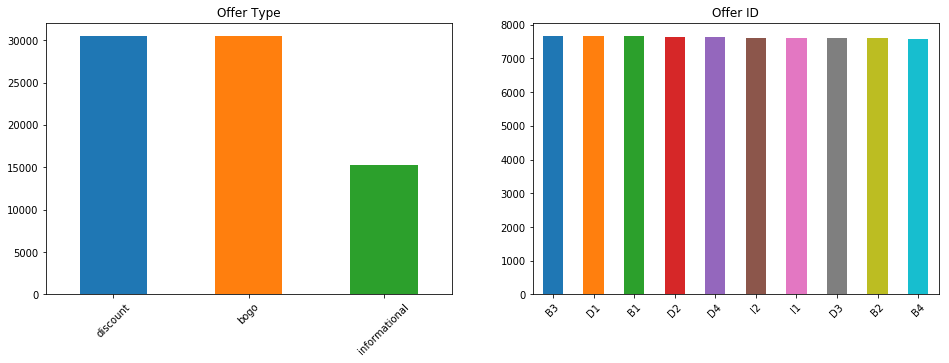

In [27]:
plt.subplot(121)
df[df.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.title('Offer Type');

plt.subplot(122)
df[df.event_offer_received == 1].offer_id.value_counts().plot(kind='bar', rot=45)
plt.title('Offer ID');

In [28]:
df[df.event_offer_received == 1].offer_id.value_counts()

B3    7677
D1    7668
B1    7658
D2    7646
D4    7632
I2    7618
I1    7617
D3    7597
B2    7593
B4    7571
Name: offer_id, dtype: int64

### 2.2 Customers Analysis

In [29]:
customers = per_customer_data(df, profile_clean)

In [30]:
customers.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [39]:
#Dropping became_member_on column, and creating new columns representing year,month,date, and member_date
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)

In [40]:
profile.head(2)

,age,gender,id,income,member_year,member_month,member_day,member_date
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,2017-07-15


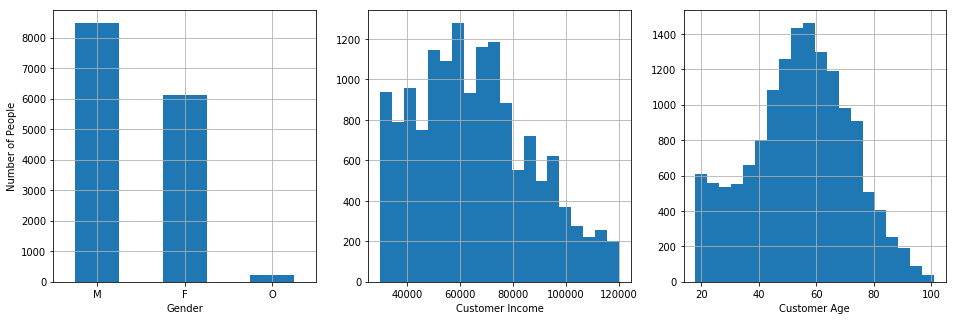

In [14]:
plt.figure(figsize=(16,5))

plt.subplot(131)
customers.gender.value_counts().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, figsize=(16,5), color='tab:blue');
plt.ylabel('Number of People');
plt.xlabel('Gender');
plt.grid();

plt.subplot(132)
cust_income = customers[customers.income_group > 0].income#_group.value_counts().reindex(range(30000, 111000,10000))
plt.xlabel('Customer Income');
plt.hist(cust_income, 20)
plt.grid()

plt.subplot(133)
cust_age = customers[customers.valid == 1].age
plt.xlabel('Customer Age');
plt.hist(cust_age, 20)
plt.grid(True)

### Plot Income Distribution as a Function of Gender
Results suggest that the minimum and maximum income for both male and female customers is approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

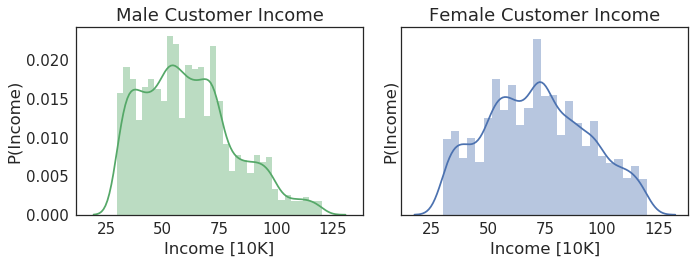

In [43]:
male_customers = profile[profile['gender'] == 'M']
female_customers = profile[profile['gender'] == 'F']

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

#### Evaluate Membership Start Year Statistics
The results suggest that most customers recently joined the Starbucks rewards program. These results also suggest that there are more male customers than female customers.

Text(0.5,1,'Subsciptions by Month and Year')

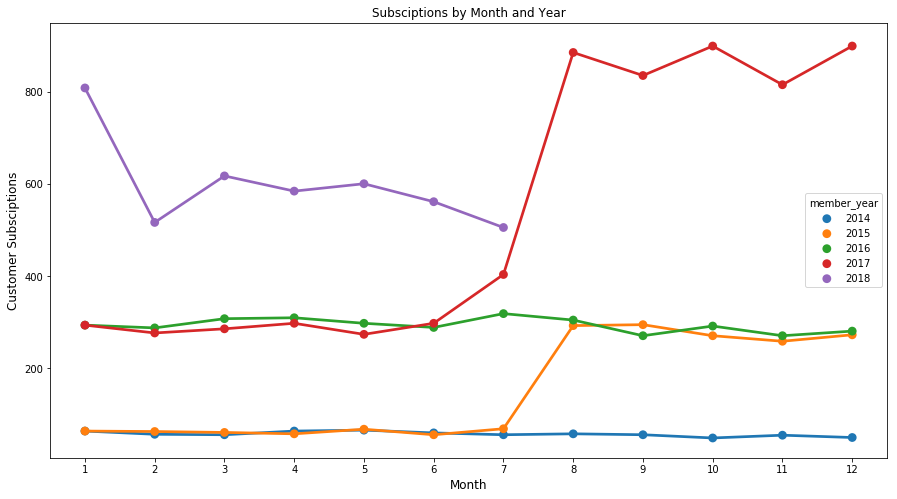

In [41]:
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Subsciptions by Month and Year')

In [48]:
!pip install progressbar

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


Text(0,0.5,'Count')

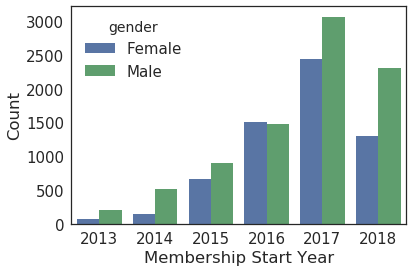

In [50]:
from exploratory_data_analysis import *
from clean_data import *

(profile, gender_integer_map) = clean_profile()
membership_date = initialize_membership_date(profile,
                                             gender_integer_map)

sns.barplot(x='startyear', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

In [51]:
membership_date.groupby('gender')['count'].sum()

gender
Female    6129
Male      8484
Name: count, dtype: int64

#### Evaluate Age Range Statistics
These results suggest that the average customer age is between 50 and 60 years old.

Rotate axis text in Python matplotlib

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

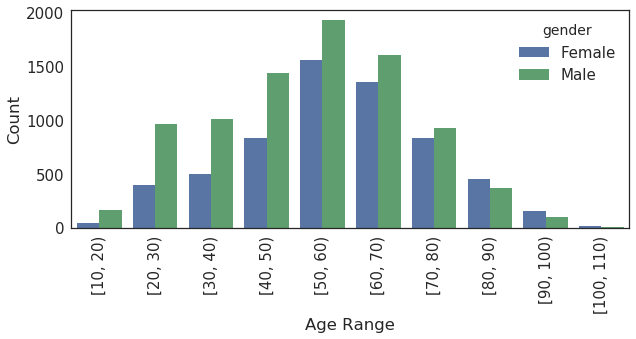

In [52]:
age_range = init_agerange(profile, gender_integer_map)

plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

Population distributions by gender, income and age. The sample provides significantly more males. Both the income and the age distribution seem to approach a normal distribution

Text(0,0.5,'$')

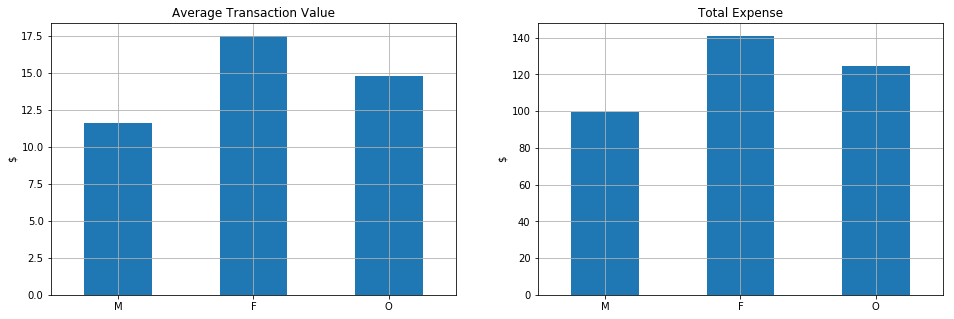

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(121)
gender_groupby = customers[customers.valid == 1].groupby('gender')
gender_transacts = gender_groupby.total_transactions.sum()
gender_expense = gender_groupby.total_expense.sum()
(gender_expense / gender_transacts).reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

plt.subplot(122)
gender_groupby.total_expense.mean().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Total Expense');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

By gender, women make more expensive tranasactions and spend more money in general. Men spent the least in both metrics.

(0, 200)

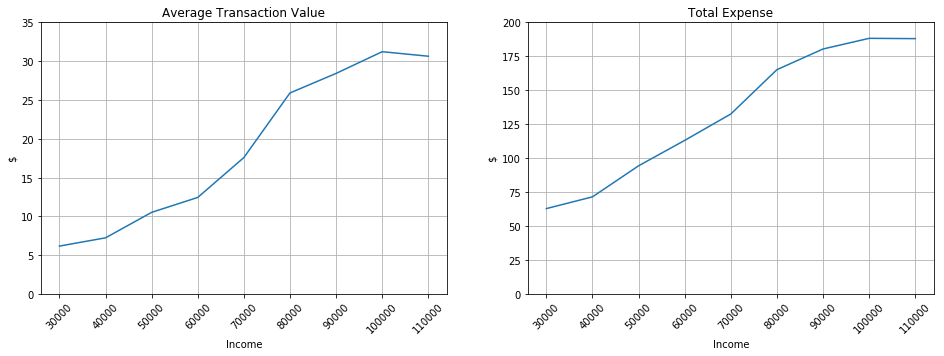

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(121)
income_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('income_group')
income_transacts = income_groupby.total_transactions.sum()
income_expense = income_groupby.total_expense.sum()
ax = (income_expense / income_transacts).reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 35)

plt.subplot(122)
ax = income_groupby.total_expense.mean().reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, color='tab:blue');
plt.title('Total Expense');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 200)

Expenses and average transaction value grow as the income grows, which is expected.

(0, 140)

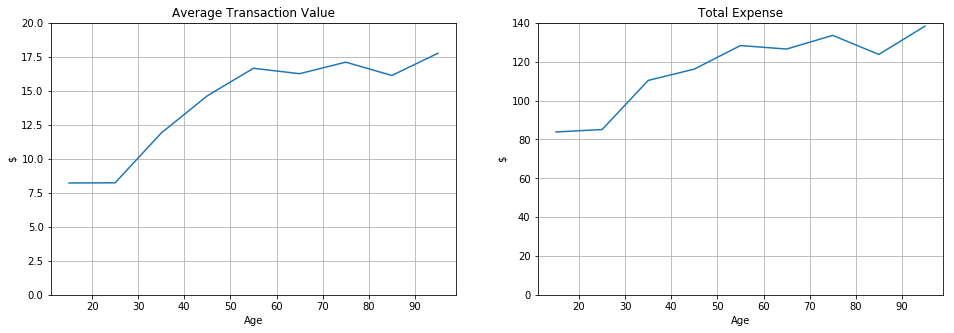

In [17]:
plt.figure(figsize=(16,5))


plt.subplot(121)
age_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('age_group')
age_transacts = age_groupby.total_transactions.sum()
age_expense = age_groupby.total_expense.sum()
ax = (age_expense / age_transacts).reindex(range(15, 96,10)).plot(kind='line', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
ax.set_ylim(0, 20)
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('$')


plt.subplot(122)
ax = age_groupby.total_expense.mean().reindex(range(15, 96,10)).plot(kind='line', rot=0, color='tab:blue');
plt.title('Total Expense');
plt.grid(True);
plt.xlabel('')
plt.xlabel('Age')
plt.ylabel('$')
ax.set_ylim(0, 140)

Similarly to income, as people get older, the value of their transactions and the total expense increases. This might be to the fact that there is a direct correlation between age and income.

### 2.3 Offer Analysis

These results suggest that distribution of offers in the simulated Starbucks mobile application data is approximately uniform. They also imply that the percentage of an offer's success ranges from ~ 6% to 75%, with the two least successful offers being informational.

Generate a plot that illustrates:

How many customers were provided a specific offer
Offer sucess rate (percentsuccess)

In [54]:
# percent_success = initialize_percent_success(portfolio,
#                                              training_data)

# f, ax = plt.subplots(figsize=(10, 4),
#                      nrows=1,
#                      ncols=2)

# ax[0].bar(percent_success.index + 1, percent_success['count'])
# ax[0].set_xticks(np.arange(0,10) + 1)
# ax[0].set_xlabel('Offer #')
# ax[0].set_ylabel('Count')

# ax[1].plot(percent_success.index + 1,
#            percent_success['percentsuccess'],
#            linewidth=3)
# ax[1].set_xticks(np.arange(0,10) + 1)
# ax[1].set_xlabel('Offer #')
# ax[1].set_ylabel('Percent Success')
# plt.tight_layout()

In [62]:
# offer_data, transaction = clean_transcript(profile)

# clean_data_csvfile = "./data/clean_data.csv"

# if os.path.exists(clean_data_csvfile):
#     clean_data = pd.read_csv(clean_data_csvfile)
# else:
#     clean_data = create_offeranalysis_dataset(profile,
#                                               portfolio,
#                                               offer_data,
#                                               transaction)

#     clean_data.to_csv(clean_data_csvfile, index=False)
    
# clean_data = clean_data.drop(columns=['time',
#                                       'customerid',
#                                       'email',
#                                       'informational'])

# column_ordering = ['offerid', 'totalamount']
# column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

# clean_data = clean_data[column_ordering]


# random_state = 3154220327

# class_label_name = 'offersuccessful'

# variables = clean_data.drop(columns=[class_label_name])
# class_label = clean_data.filter([class_label_name])

# (X_train,
#  X_test,
#  y_train,
#  y_test) = train_test_split(variables.values,
#                             class_label.values,
#                             test_size=0.2,
#                             random_state=random_state)

# variable_names = variables.columns[2:]

# offerid_train = X_train[:, 0]
# totalamount_train = X_train[:, 1]
# X_train = X_train[:, 2:].astype('float64')

# offerid_test = X_test[:, 0]
# totalamount_test = X_test[:, 1]
# X_test = X_test[:, 2:].astype('float64')

# y_train = y_train.ravel()
# y_test = y_test.ravel()

# training_variables = pd.DataFrame(X_train, columns=variable_names)
# training_labels = pd.DataFrame(y_train, columns=[class_label_name])
# training_offerid = pd.DataFrame(offerid_train, columns=['offerid'])

# training_data = pd.concat([training_offerid,
#                            training_variables,
#                            training_labels], axis=1)

# training_data = training_data.drop(columns=['difficulty',
#                                             'durationdays',
#                                             'reward',
#                                             'bogo',
#                                             'discount',
#                                             'mobile',
#                                             'social',
#                                             'web'])

# percent_success = initialize_percent_success(portfolio,
#                                              training_data)
# explore_customer_offer(0, percent_success, training_data, gender_integer_map)

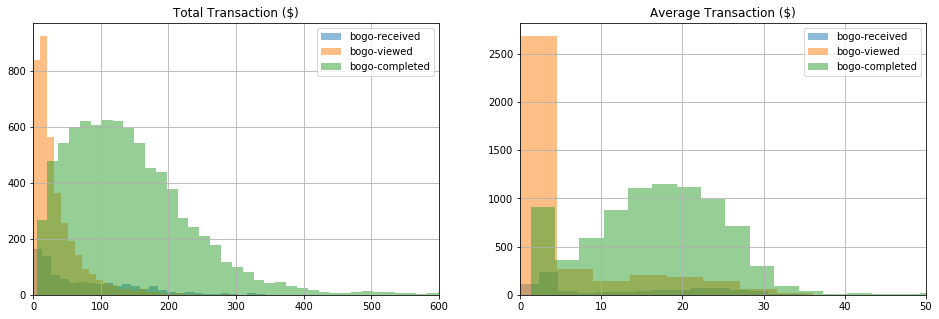

In [18]:
plot_offer_expense(customers, 'bogo')

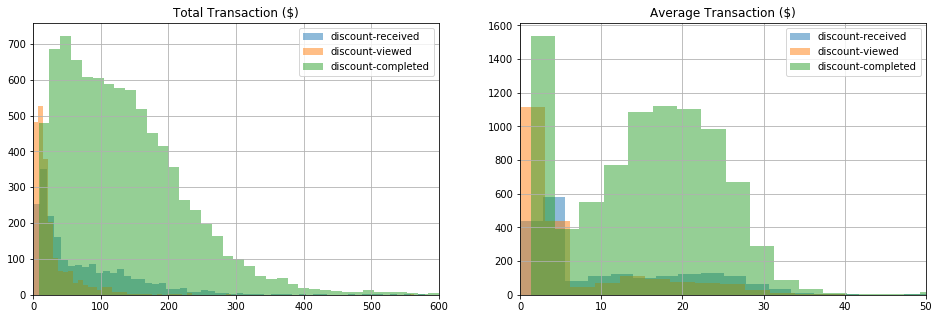

In [19]:
plot_offer_expense(customers, 'discount')

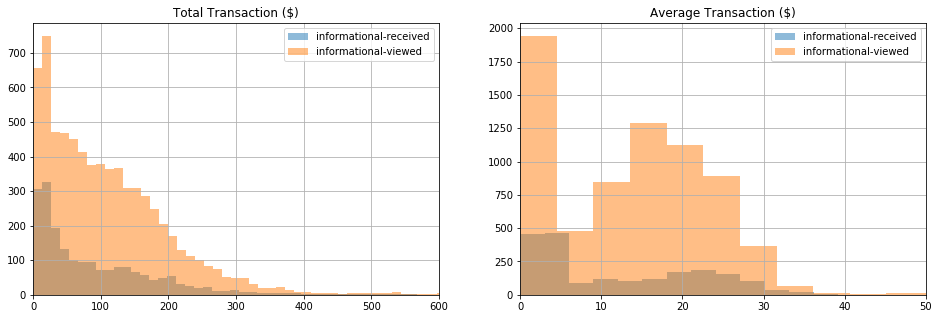

In [20]:
plot_offer_expense(customers, 'informational')

It is clear that customer that complete the offers (or view them in the case of informational ones) spend more money per transaction and in total

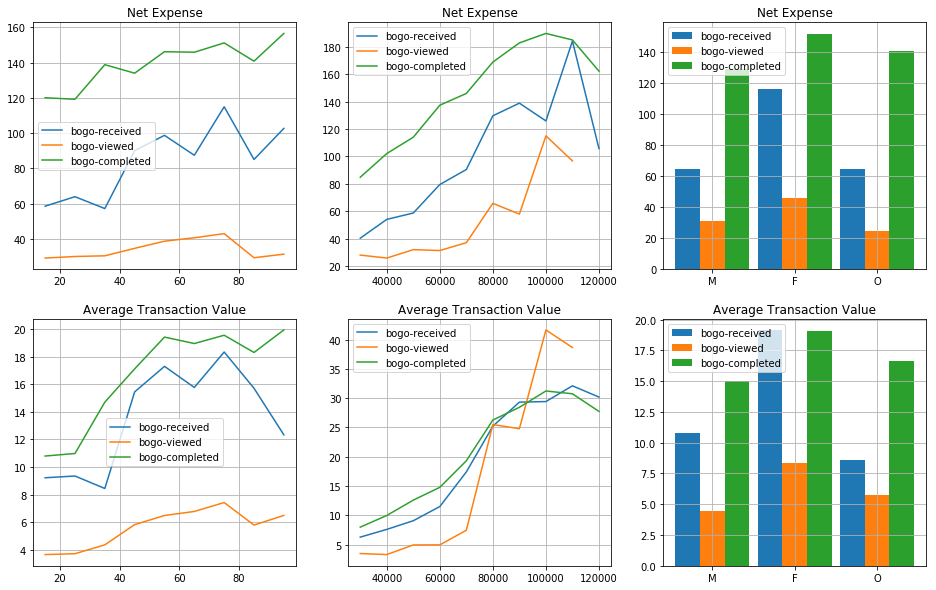

In [21]:
plot_offer_expense_by(customers, 'bogo')

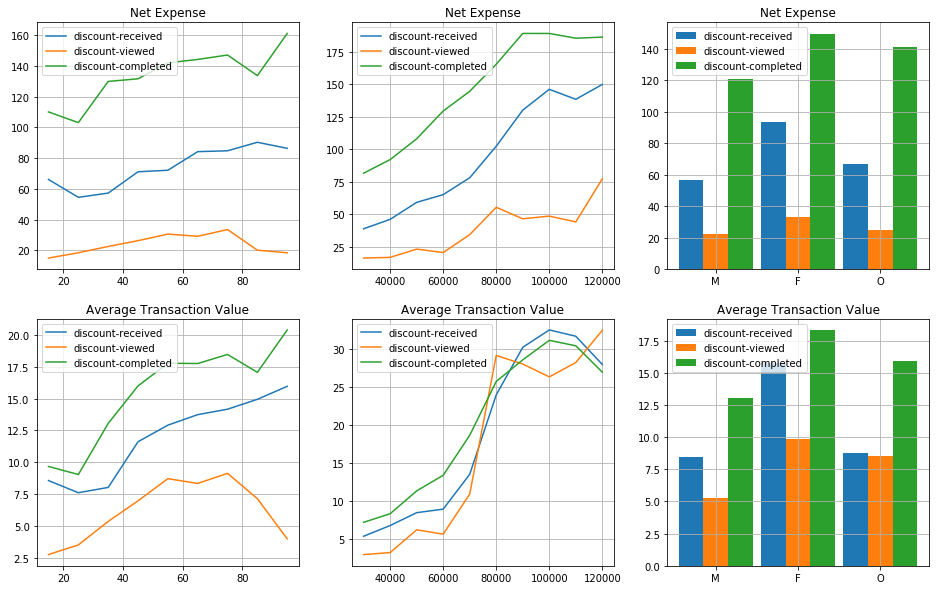

In [22]:
plot_offer_expense_by(customers, 'discount')

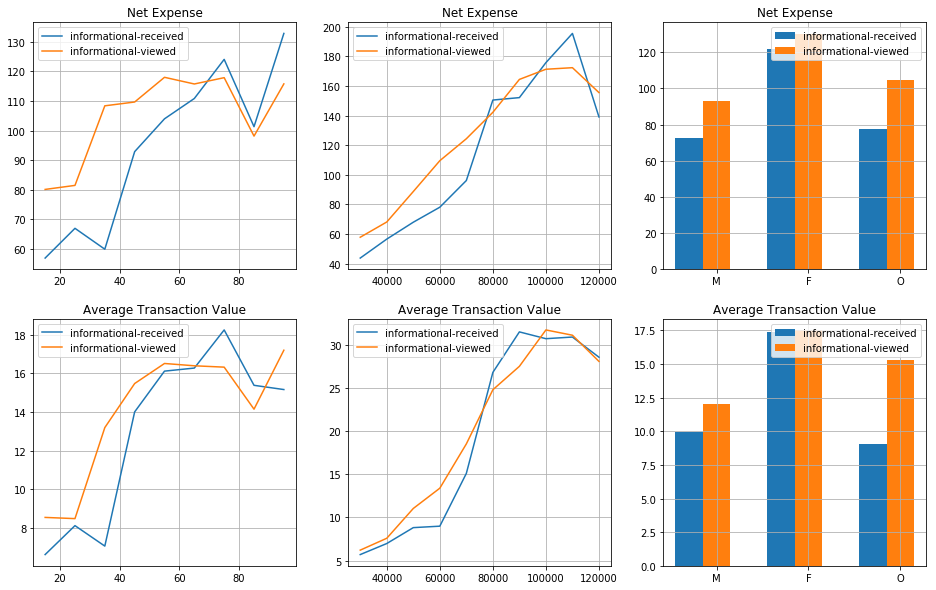

In [23]:
plot_offer_expense_by(customers, 'informational')

The spending patterns are similar for customers that received, viewed and completed offers. It's important to note that for informational offers, they seem to be more relevant for younger customers. Similarly, customers that make less than $80,000 don't seem to be impacted by this kind of offers.

In [24]:
customers.corr().style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


Correlation shows that the offer completions have some impact on the spending habits of customers. Also, income and gender seem to have some impact as well

Compute the event type distribution

In [55]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


Several distribution plots can be presented to give an idea regarding the customers' demographic.

In [67]:
profile.head(1)

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


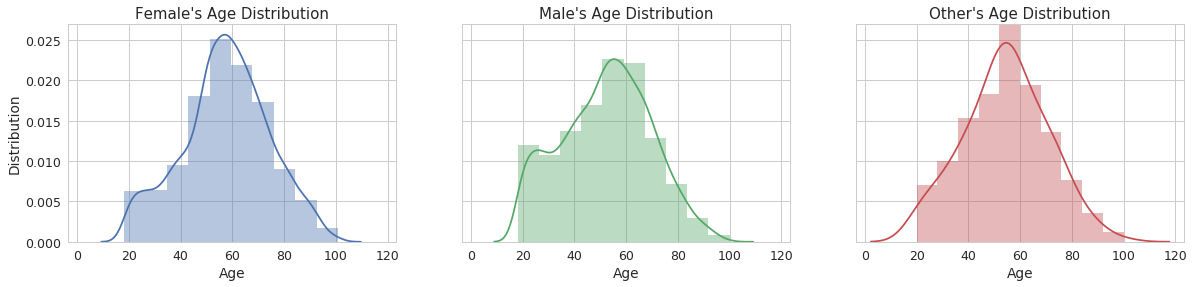

In [70]:
df_profile = profile

sns.set(style = 'whitegrid', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(df_profile[df_profile['gender'] == 'F']['age'], bins = 10, color = palette[0]);
plt.title('Female\'s Age Distribution')
plt.xlabel('Age')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(df_profile[df_profile['gender'] == 'M']['age'], bins = 10, color = palette[1]);
plt.title('Male\'s Age Distribution')
plt.xlabel('Age')

plt.sca(ax[2])
sns.distplot(df_profile[df_profile['gender'] == 'O']['age'], bins = 10, color = palette[2]);
plt.title('Other\'s Age Distribution')
plt.xlabel('Age')
plt.show()

# fig.savefig('figures/profile_age.svg', dpi = 300)

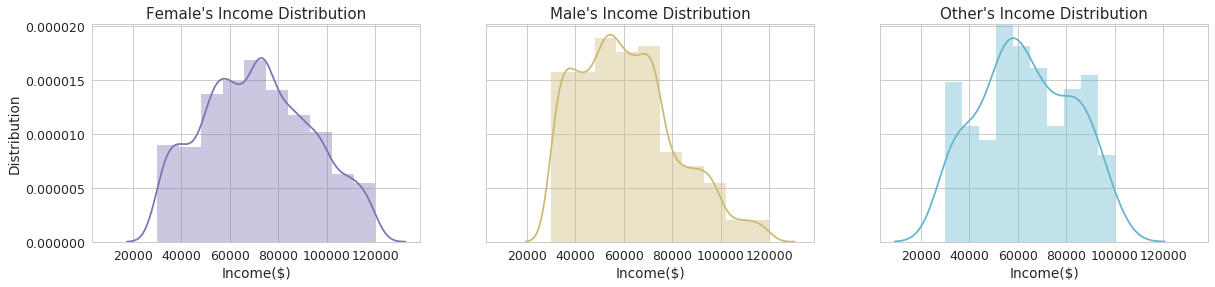

In [72]:
sns.set(style = 'whitegrid', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 3, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(df_profile[df_profile['gender'] == 'F']['income'], bins = 10, color = palette[3]);
plt.title('Female\'s Income Distribution')
plt.xlabel('Income($)')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(df_profile[df_profile['gender'] == 'M']['income'], bins = 10, color = palette[4]);
plt.title('Male\'s Income Distribution')
plt.xlabel('Income($)')

plt.sca(ax[2])
sns.distplot(df_profile[df_profile['gender'] == 'O']['income'], bins = 10, color = palette[5]);
plt.title('Other\'s Income Distribution')
plt.xlabel('Income($)')
plt.show()

# fig.savefig('figures/profile_income.svg', dpi = 300)

In [77]:
def portfolio_clean(df = portfolio):
    '''
    Clean portfolio dataframe

    Args:
        df (pandas.DataFrame): DataFrame of portfolio

    Returns:
        df (pandas.DataFrame): Cleaned DataFrame of portfolio
    '''
    df = df.copy()
    offer_dummies = pd.get_dummies(df['offer_type'], prefix = 'offer')
    channels = df['channels'].str.join(sep = '*').str.get_dummies(sep = '*').add_prefix('channel_') # indexing the list within the column
    df = df.drop(['channels', 'offer_type'], axis = 1)
    df = df.rename(columns = {'id': 'offer_id', 'reward': 'offer_reward', 'difficulty': 'offer_difficulty', 'duration': 'offer_duration'})
    columns_order = ['offer_id', 'offer_reward', 'offer_difficulty', 'offer_duration']
    df = df.reindex(columns = columns_order)
    df = pd.concat([df, offer_dummies, channels], axis = 1)
    df = df.reset_index(drop=True)
    return df

def profile_clean(df = profile):
    '''
    Clean profile dataframe

    Args:
        df (pandas.DataFrame): DataFrame of profile

    Returns:
        df (pandas.DataFrame): Cleaned DataFrame of profile
    '''
    df = df.copy()
    df = df.dropna()
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format = '%Y%m%d')
    df['days_membership'] = (datetime.datetime.today().date() - df['became_member_on'].dt.date).dt.days
    df = df.rename(columns = {'id': 'customer_id'})
    columns_order = ['customer_id', 'gender', 'age', 'income', 'became_member_on', 'days_membership']
    df = df.reindex(columns = columns_order)
    df = df.reset_index(drop=True)
    return df

def transcript_clean(df = transcript, profile = df_profile):
    '''
    Clean transcript dataframe

    Args:
        df (pandas.DataFrame): DataFrame of transcript

    Returns:
        df_o (pandas.DataFrame): Cleaned DataFrame containing offers
        df_t (pandas.DataFrame): Cleaned DataFrame containing transactions
    '''
    df = df.copy()
    data_to_keep = df['person'].isin(profile['customer_id'])
    df = df[data_to_keep]
    df['time'] = df['time']/24
    
    filter_row = df['event'] == 'transaction'
    non_offer_df = df[filter_row]
    df_t = pd.DataFrame(data = non_offer_df)
    df_t = df_t.drop(['value', 'event'], axis = 1)
    df_t['amount'] = non_offer_df['value'].apply(lambda x: list(x.values())[0])
    df_t = df_t.rename(columns = {'person': 'customer_id'})
    df_t = df_t.reset_index(drop=True)
    
    filter_row = df['event'] != 'transaction'
    offer_df = df[filter_row]
    df_o = pd.DataFrame(data = offer_df)
    dummies = pd.get_dummies(df_o['event'])
    df_o = df_o.drop(['event', 'value'], axis = 1)
    df_o['offer_id'] = offer_df['value'].apply(lambda x: list(x.values())[0])
    df_o = df_o.rename(columns = {'person': 'customer_id'})
    df_o = pd.concat([df_o, dummies], axis = 1)
    columns_order = ['customer_id', 'offer_id', 'time', 'offer completed', 'offer received', 'offer viewed']
    df_o = df_o.reindex(columns = columns_order)
    df_o = df_o.reset_index(drop=True)
    
    return df_o, df_t

# Read in successful offer, view, and receive:
def clean_data(df_portfolio, df_profile, df_offer, df_transaction):
    '''
    Combine df_portfolio, df_profile, df_offer, and
    df_transaction

    Args:
        df_portfolio (pandas.DataFrame): Clean DataFrame of portfolio
        df_profile (pandas.DataFrame): Clean DataFrame of profile
        df_offer (pandas.DataFrame): Clean DataFrame of offer
        df_transaction (pandas.DataFrame): Clean DataFrame of transaction
    Returns:
        clean_data (pandas.DataFrame): DataFrame containing information from
                                       all of the data input in the desired 
                                       format
    '''
    clean_data = []
    customer_list = df_profile['customer_id'].unique().tolist()
    for customer_id in customer_list:
        index_customer = df_profile[df_profile['customer_id'] == customer_id]
        offer_filtered = df_offer[df_offer['customer_id'] == customer_id]
        transaction_id = df_transaction[df_transaction['customer_id'] == customer_id]
        
        offer_complete = offer_filtered[offer_filtered['offer completed'] == 1]
        offer_view = offer_filtered[offer_filtered['offer viewed'] == 1]
        offer_receive = offer_filtered[offer_filtered['offer received'] == 1]
        
        # Loop through customers who obtained offers
        for index in range(len(offer_receive)):
            offer_id = offer_receive.iloc[index]['offer_id']
            offer_info = df_portfolio[df_portfolio['offer_id'] == offer_id]
            duration = offer_info['offer_duration'].values[0]
            portfolio = offer_info[['offer_duration', 'offer_reward', 'offer_difficulty', 
                                    'offer_bogo', 'offer_discount', 'offer_informational',
                                    'channel_email', 'channel_mobile', 'channel_social', 
                                    'channel_web']].values[0]

            customer = index_customer[['gender', 'age', 'income', 'days_membership', 'became_member_on']].values[0]

            offer_start = offer_receive.iloc[index]['time']
            offer_end = offer_start + duration

            #np.logical_and is used instead of and to avoid ambiguous truth value
            transaction_filter = np.logical_and(transaction_id['time'] >= offer_start, 
                                                transaction_id['time'] <= offer_end)
            completed_filter =  np.logical_and(offer_complete['time'] >= offer_start, 
                                               offer_complete['time'] <= offer_end)
            viewed_filter = np.logical_and(offer_view['time'] >= offer_start, 
                                           offer_view['time'] <= offer_end)

            offer_finished = (completed_filter.sum() > 0) and (viewed_filter.sum() > 0) # assign 1 if offer is fulfilled, 0 if not
            period_transaction = transaction_id[transaction_filter]['amount'].sum() # amount of transaction during the offer 

            data_entry_1 = [offer_id, customer_id, int(offer_finished), period_transaction]
            data_entry_2 = list(portfolio)
            data_entry_3 = list(customer)

            data = data_entry_1 + data_entry_2 + data_entry_3

            clean_data.append(data)

    column_names = ['offer_id', 'customer_id', 'offer_completed', 'money_spent', # data entry 1
                    'offer_duration', 'offer_reward', 'offer_difficulty', 'offer_bogo',          # data entry 2
                    'offer_discount', 'offer_informational', 'channel_email', 'channel_mobile',  # data entry 2
                    'channel_social', 'channel_web',                                             # data entry 2
                    'gender', 'age', 'income', 'days_membership', 'became_member_on'] # data entry 3

    clean_data = pd.DataFrame(data = clean_data, columns = column_names)
    # Grab the joining year
    clean_data['became_member_on'] = clean_data['became_member_on'].dt.year
    
    return clean_data

In [79]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [81]:
# df_portfolio = portfolio_clean()
# df_profile = profile_clean()
# df_offer, df_transaction = transcript_clean()

# processed_data = clean_data(df_portfolio, df_profile, df_offer, df_transaction)

References:

https://github.com/MohanCR97/Udacity-Data_Scientist_Nanodegree/tree/master/Starbucks_CapstoneProject

https://github.com/mspcvsp/StarbucksCapstoneChallenge

https://github.com/prabowst/udacity-dsnd-capstone-starbucks

https://github.com/dkhundley/starbucks-ml-capstone/blob/master/Hundley-Starbucks-Project.ipynb

https://github.com/vmandalpu/Starbucks_Customer_Segmentation/blob/master/3_Clustering%20Algorithms%20and%20Visualization.ipynb

https://github.com/Aete/Udacity_DSND_Starbucks_Capstone_Challenge/blob/master/Starbucks_Capstone_notebook.ipynb

https://github.com/karagain/Kar-Starbucks-Project/blob/master/Kar_Starbucks_Capstone_notebook.ipynb

https://github.com/smithatu/Starbucks_Capstone_Project/blob/master/Starbucks_Capstone_notebook.ipynb

https://github.com/vasilyor/StarbucksCapstoneChallenge/blob/master/Starbucks_Capstone_notebook.ipynb

https://github.com/hannansatopay/Starbucks-Capstone-Challenge/blob/master/Starbucks_Capstone_notebook.ipynb

https://github.com/damhurmuller/starbucks-capstone-mle/blob/master/Starbucks_Capstone_notebook.ipynb

### Conclusion
The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has four steps. First, I combined offer portfolio, customer profile, and transaction data. Second, I assessed the accuracy and F1-score of a naive model that assumes all offers were successful. Third, I compared the performance of logistic regression, random forest, and gradient boosting models. This analysis suggests that a random forest model has the best training data accuracy and F1-score. Fourth, I refined random forest model hyperparameters using a grid search. My analysis suggests that the resulting random forest model has an training data accuracy of 0.753 and an F1-score of 0.746. The test data set accuracy of 0.736 and F1-score of 0.727 suggests that the random forest model I constructed did not overfit the training data.

"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. A random forest classifier is an example of a model that estimates feature importance during training. My analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top five features based on their importance are:

1. Offer difficulty (how much money a customer must spend to complete an offer)  
2. Offer duration   
3. Offer reward  
4. Customer income  
5. Whether a customer created an account on the Starbucks rewards mobile application in 2018  

Since the top three features are associated with an customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer's success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.